In [1]:
#import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from scipy.stats import mannwhitneyu

In [98]:
df = pd.read_csv("../../Models_and_data/main_analysis/cleaned_asv_df.csv")
if 'Row_Sum' in df.columns:
    df = df.drop(columns=['Row_Sum'])
filtered_df = df

reads_filtered = df.iloc[:,1:-13]
group_labels = filtered_df['Group']

# Load all CSV files into DataFrames
completed_matrix = pd.read_csv("rpca_results/completed_matrix.csv")
distance_matrix = pd.read_csv("rpca_results/distance_matrix.csv")
explained_variance = pd.read_csv("rpca_results/explained_variance.csv")
feature_weights = pd.read_csv("rpca_results/feature_weights.csv")
filtered_reads = pd.read_csv("rpca_results/filtered_reads.csv")
pca_sample_scores = pd.read_csv("rpca_results/pca_sample_scores.csv")
singular_values = pd.read_csv("rpca_results/singular_values.csv")

In [99]:
# Define global settings for publication-style parameters
FIG_WIDTH = 8            # Width of individual figures
FIG_HEIGHT = 6           # Height of individual figures
DPI = 600                # Resolution for saving figures
FONT_SIZE = 22           # Base font size for text
LABEL_SIZE = 22          # Font size for axis labels
TITLE_SIZE = 20          # Font size for titles
TICK_SIZE = 20           # Font size for tick labels
LEGEND_SIZE = 19         # Font size for legend
EDGE_COLOR = 'k'         # Edge color for scatter points
COLOR_MAP = 'viridis'    # Color map for continuous variables
ALPHA_SCATTER = 0.6      # Opacity for scatter points
ALPHA_DENSITY = 0.3      # Opacity for density plot

# Update matplotlib's global parameters
plt.rcParams.update({
    'font.size': FONT_SIZE,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.labelsize': LABEL_SIZE,
    'axes.titlesize': TITLE_SIZE,
    'xtick.labelsize': TICK_SIZE,
    'ytick.labelsize': TICK_SIZE,
    'legend.fontsize': LEGEND_SIZE
})

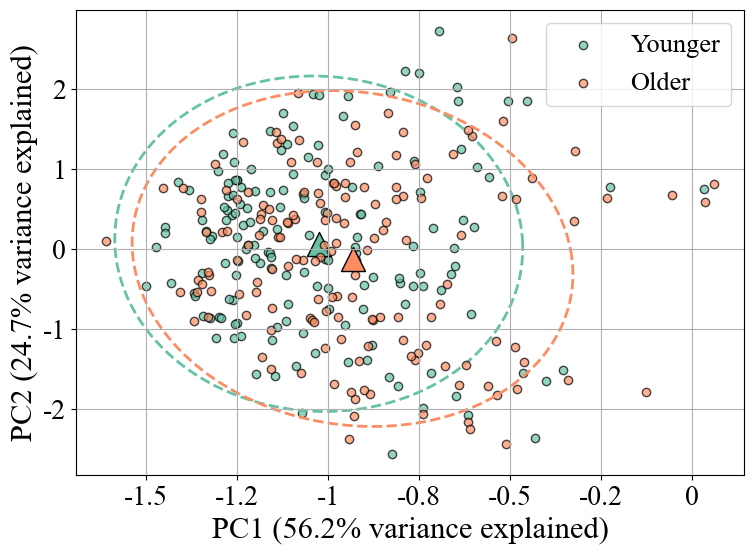

In [100]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import FuncFormatter
import numpy as np
from scipy import linalg
import pandas as pd

# Define a formatter function
def flexible_format(x, pos):
    if x.is_integer():
        return f'{int(x)}'
    else:
        return f'{x:.1f}'

# Function to draw a confidence ellipse
def draw_confidence_ellipse(ax, x, y, n_std=2, facecolor='none', edgecolor='black', **kwargs):
    """
    Draw a confidence ellipse of n_std standard deviations.
    """
    if len(x) < 2:
        # Not enough points to calculate covariance
        return

    cov = np.cov(x, y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # Eigenvalues and eigenvectors
    eigvals, eigvecs = linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # Calculate the angle between the x-axis and the largest eigenvector
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

    # Width and height of the ellipse to cover n_std standard deviations
    width, height = 2 * n_std * np.sqrt(eigvals)

    ellipse = Ellipse((mean_x, mean_y), width, height, angle=angle,
                      facecolor=facecolor, edgecolor=edgecolor, **kwargs)
    ax.add_patch(ellipse)

# Modified plotting function
def plot_pca_with_groups(pca_sample_scores, explained_variance, group_series):
    """
    Plots PCA scores colored by group membership, with confidence ellipses and centroids.

    Parameters:
    - pca_sample_scores: DataFrame with PCA scores, columns named "0", "1", etc.
    - explained_variance: Series or list with explained variance for each principal component.
    - group_series: Pandas Series with categorical group labels.
    """

    # Combine into a single DataFrame
    combined_df = pca_sample_scores.copy()
    combined_df['Group'] = group_series

    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))  # Adjust FIG_WIDTH and FIG_HEIGHT as needed

    # Identify unique groups
    groups = combined_df['Group'].unique()

    # Define a custom palette with green and orange
    custom_palette = ["#fc8d62", "#66c2a5"]

    # Create a dictionary mapping each group to a color
    color_mapping = {group: color for group, color in zip(groups, custom_palette)}

    # Group by 'Group'
    for idx, (group, group_data) in enumerate(combined_df.groupby('Group')):
        x = group_data["0"]
        y = group_data["1"]

        # Scatter plot for the group using the custom color
        ax.scatter(
            x, y,
            label=group,
            color=color_mapping[group],
            alpha=0.7,
            edgecolor='k'
        )

        # Draw 95% confidence ellipse using the custom color
        draw_confidence_ellipse(
            ax, x, y,
            n_std=2,
            edgecolor=color_mapping[group],
            linestyle='--',
            linewidth=2
        )

        # Calculate and plot centroid using the custom color
        centroid_x = x.mean()
        centroid_y = y.mean()
        ax.scatter(
            centroid_x, centroid_y,
            marker='^',  # Triangle marker
            color=color_mapping[group],
            edgecolor='k',
            s=300  # Size of the centroid marker
            #label=f'{group} Centroid'
        )

    # Add legend, handling duplicate labels for centroids
    handles, labels = ax.get_legend_handles_labels()

    # Define a custom label mapping if needed
    custom_label_mapping = {
        "Worse": "Older",
        "Better": "Younger",
        # Add more mappings as needed
    }

    # Update labels based on the custom mapping
    updated_labels = [custom_label_mapping.get(label, label) for label in labels]

    # Remove duplicate labels by creating a dictionary
    by_label = dict(zip(updated_labels, handles))

    # Create the legend with updated labels
    ax.legend(by_label.values(), by_label.keys(), fontsize=LEGEND_SIZE)

    # Add axis labels with explained variance
    ax.set_xlabel(f'PC1 ({explained_variance.iloc[0,0] * 100:.1f}% variance explained)', fontsize=LABEL_SIZE)
    ax.set_ylabel(f'PC2 ({explained_variance.iloc[1,0] * 100:.1f}% variance explained)', fontsize=LABEL_SIZE)
    ax.grid(True)

    # Set flexible formatting for x-axis and y-axis
    ax.xaxis.set_major_formatter(FuncFormatter(flexible_format))
    ax.yaxis.set_major_formatter(FuncFormatter(flexible_format))

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig("pca_normal_final.png", format="png", dpi=600, bbox_inches="tight")
    plt.show()

plot_pca_with_groups(
    pca_sample_scores=pca_sample_scores,
    explained_variance=explained_variance,
    group_series=filtered_df["Group"]
)


In [101]:
# Load data from ordination file
ordination_file = 'phylo_rpca_results/ordination.txt'

# Extract variance explained from the "Proportion explained" line
with open(ordination_file, 'r') as file:
    lines = file.readlines()
    explained_variance_phylo = [float(value) for value in lines[4].strip().split('\t')]

# Extract PCA scores from "Site" section (starting at line where it appears)
pca_scores_start = lines.index("Site\t311\t3\n") + 1
pca_scores = [line.strip().split('\t') for line in lines[pca_scores_start:pca_scores_start + 311]]
pca_scores_df_phylo = pd.DataFrame(pca_scores, columns=['Sample', 'PC1', 'PC2', 'PC3']).astype({'PC1': float, 'PC2': float, 'PC3': float})



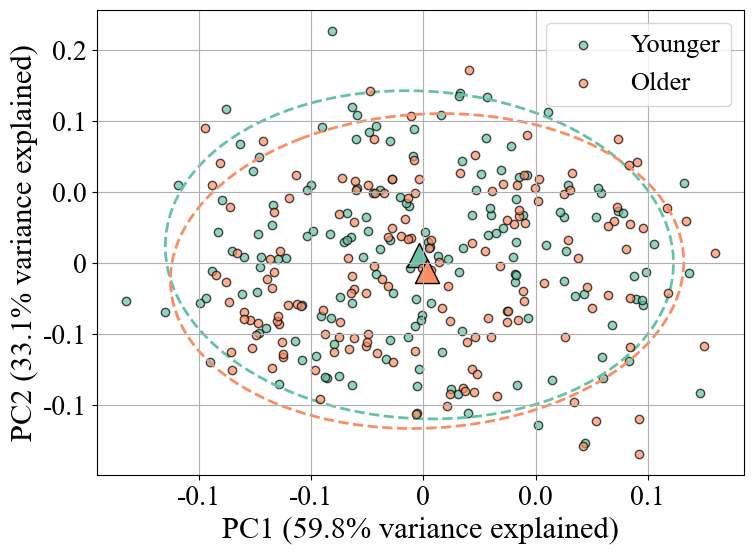

In [102]:
# Modified plotting function
def plot_pca_with_groups2(pca_sample_scores, explained_variance, group_series):
    """
    Plots PCA scores colored by group membership, with confidence ellipses and centroids.

    Parameters:
    - pca_sample_scores: DataFrame with PCA scores, columns named "0", "1", etc.
    - explained_variance: Series or list with explained variance for each principal component.
    - group_series: Pandas Series with categorical group labels.
    """

    # Combine into a single DataFrame
    combined_df = pca_sample_scores.copy()
    combined_df['Group'] = group_series

    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))  # Adjust FIG_WIDTH and FIG_HEIGHT as needed

    # Identify unique groups
    groups = combined_df['Group'].unique()

    # Define a custom palette with green and orange
    custom_palette = ["#fc8d62", "#66c2a5"]

    # Create a dictionary mapping each group to a color
    color_mapping = {group: color for group, color in zip(groups, custom_palette)}

    # Group by 'Group'
    for idx, (group, group_data) in enumerate(combined_df.groupby('Group')):
        x = group_data["PC1"]
        y = group_data["PC2"]

        # Scatter plot for the group using the custom color
        ax.scatter(
            x, y,
            label=group,
            color=color_mapping[group],
            alpha=0.7,
            edgecolor='k'
        )

        # Draw 95% confidence ellipse using the custom color
        draw_confidence_ellipse(
            ax, x, y,
            n_std=2,
            edgecolor=color_mapping[group],
            linestyle='--',
            linewidth=2
        )

        # Calculate and plot centroid using the custom color
        centroid_x = x.mean()
        centroid_y = y.mean()
        ax.scatter(
            centroid_x, centroid_y,
            marker='^',  # Triangle marker
            color=color_mapping[group],
            edgecolor='k',
            s=300  # Size of the centroid marker
            #label=f'{group} Centroid'
        )

    # Add legend, handling duplicate labels for centroids
    handles, labels = ax.get_legend_handles_labels()

    # Define a custom label mapping if needed
    custom_label_mapping = {
        "Worse": "Older",
        "Better": "Younger",
        # Add more mappings as needed
    }

    # Update labels based on the custom mapping
    updated_labels = [custom_label_mapping.get(label, label) for label in labels]

    # Remove duplicate labels by creating a dictionary
    by_label = dict(zip(updated_labels, handles))

    # Create the legend with updated labels
    ax.legend(by_label.values(), by_label.keys(), fontsize=LEGEND_SIZE)

    # Add axis labels with explained variance
    ax.set_xlabel(f'PC1 ({explained_variance[0] * 100:.1f}% variance explained)', fontsize=LABEL_SIZE)
    ax.set_ylabel(f'PC2 ({explained_variance[1] * 100:.1f}% variance explained)', fontsize=LABEL_SIZE)
    ax.grid(True)

    # Set flexible formatting for x-axis and y-axis
    ax.xaxis.set_major_formatter(FuncFormatter(flexible_format))
    ax.yaxis.set_major_formatter(FuncFormatter(flexible_format))

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig("pca_phylo_final.png", format="png", dpi=600, bbox_inches="tight")
    plt.show()

plot_pca_with_groups2(
    pca_sample_scores=pca_scores_df_phylo,
    explained_variance=explained_variance_phylo,
    group_series=filtered_df["Group"]
)

In [103]:
bc_scores = pd.read_csv("../pcoa_bc_scores.csv")
bc_scores = bc_scores.drop(columns='Unnamed: 0')
bc_variance = pd.read_csv("../pcoa_bc_explained_variance.csv")
bc_variance = bc_variance.drop(columns='Unnamed: 0')

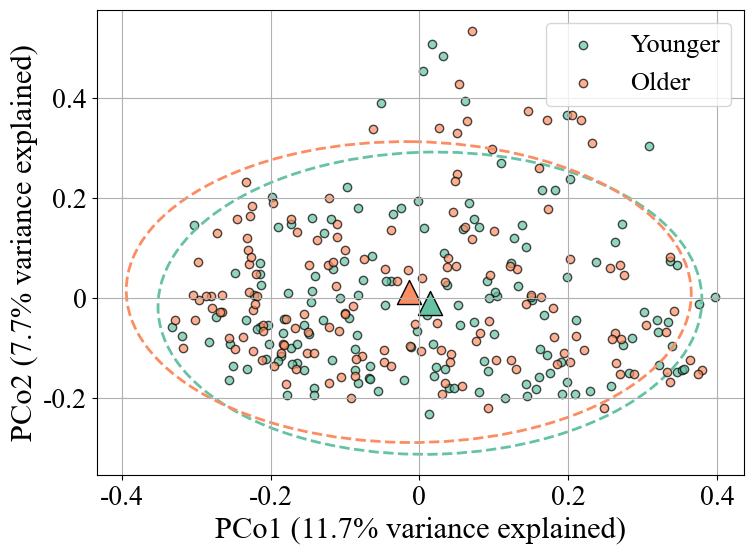

In [106]:
# Modified plotting function
def plot_pca_with_groups2(pca_sample_scores, explained_variance, group_series):
    """
    Plots PCA scores colored by group membership, with confidence ellipses and centroids.

    Parameters:
    - pca_sample_scores: DataFrame with PCA scores, columns named "0", "1", etc.
    - explained_variance: Series or list with explained variance for each principal component.
    - group_series: Pandas Series with categorical group labels.
    """

    # Combine into a single DataFrame
    combined_df = pca_sample_scores.copy()
    combined_df['Group'] = group_series

    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))  # Adjust FIG_WIDTH and FIG_HEIGHT as needed

    # Identify unique groups
    groups = combined_df['Group'].unique()

    # Define a custom palette with green and orange
    custom_palette = ["#fc8d62", "#66c2a5"]

    # Create a dictionary mapping each group to a color
    color_mapping = {group: color for group, color in zip(groups, custom_palette)}

    # Group by 'Group'
    for idx, (group, group_data) in enumerate(combined_df.groupby('Group')):
        x = group_data["PC1"]
        y = group_data["PC2"]

        # Scatter plot for the group using the custom color
        ax.scatter(
            x, y,
            label=group,
            color=color_mapping[group],
            alpha=0.7,
            edgecolor='k'
        )

        # Draw 95% confidence ellipse using the custom color
        draw_confidence_ellipse(
            ax, x, y,
            n_std=2,
            edgecolor=color_mapping[group],
            linestyle='--',
            linewidth=2
        )

        # Calculate and plot centroid using the custom color
        centroid_x = x.mean()
        centroid_y = y.mean()
        ax.scatter(
            centroid_x, centroid_y,
            marker='^',  # Triangle marker
            color=color_mapping[group],
            edgecolor='k',
            s=300  # Size of the centroid marker
            #label=f'{group} Centroid'
        )

    # Add legend, handling duplicate labels for centroids
    handles, labels = ax.get_legend_handles_labels()

    # Define a custom label mapping if needed
    custom_label_mapping = {
        "Worse": "Older",
        "Better": "Younger",
        # Add more mappings as needed
    }

    # Update labels based on the custom mapping
    updated_labels = [custom_label_mapping.get(label, label) for label in labels]

    # Remove duplicate labels by creating a dictionary
    by_label = dict(zip(updated_labels, handles)) 

    # Create the legend with updated labels
    ax.legend(by_label.values(), by_label.keys(), fontsize=LEGEND_SIZE)

    # Add axis labels with explained variance
    ax.set_xlabel(f'PCo1 ({explained_variance.iloc[0,0]:.1f}% variance explained)', fontsize=LABEL_SIZE)
    ax.set_ylabel(f'PCo2 ({explained_variance.iloc[1,0]:.1f}% variance explained)', fontsize=LABEL_SIZE)
    ax.grid(True)

    # Set flexible formatting for x-axis and y-axis
    ax.xaxis.set_major_formatter(FuncFormatter(flexible_format))
    ax.yaxis.set_major_formatter(FuncFormatter(flexible_format))

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig("pcoa_bc_final.png", format="png", dpi=600, bbox_inches="tight")
    plt.show()

plot_pca_with_groups2(
    pca_sample_scores=bc_scores,
    explained_variance=bc_variance,
    group_series=filtered_df["Group"]
)

C:\Users\MEDV3721\AppData\Local\Temp\ipykernel_8780\4089925829.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlabel(f'PC1 ({explained_variance.iloc[0][0] * 100:.1f}% variance explained)')
C:\Users\MEDV3721\AppData\Local\Temp\ipykernel_8780\4089925829.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(f'PC2 ({explained_variance.iloc[1][0] * 100:.1f}% variance explained)')


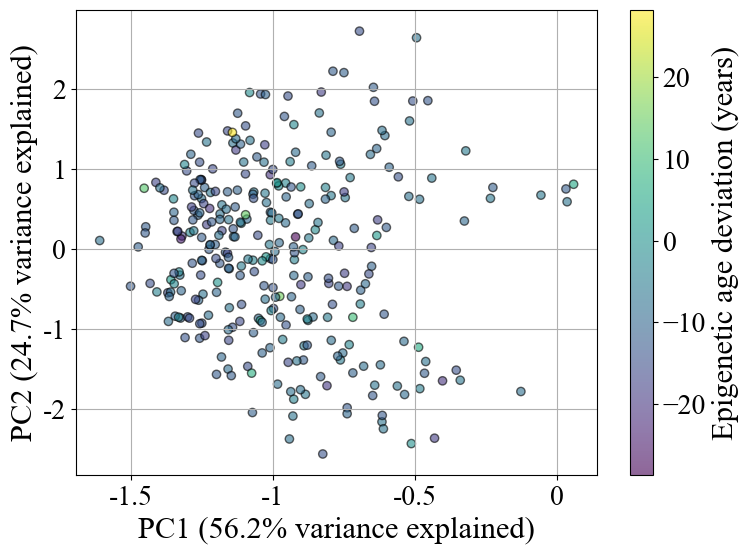

In [ ]:
# Define a formatter function
def flexible_format(x, pos):
    if x.is_integer():
        return f'{int(x)}'
    else:
        return f'{x:.1f}'

# Function to plot PCA with Epigenetic Deviation as the color gradient
def plot_pca_with_epigenetic_deviation(pca_sample_scores, explained_variance, epigenetic_deviation):
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

    # Scatter plot with color gradient based on Epigenetic Deviation
    scatter = ax.scatter(
        pca_sample_scores["0"],  # PC1
        pca_sample_scores["1"],  # PC2
        c=epigenetic_deviation,   # Color by Epigenetic Deviation
        cmap=COLOR_MAP,
        alpha=ALPHA_SCATTER,
        edgecolor=EDGE_COLOR
    )

    # Add color bar for continuous variable
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Epigenetic age deviation (years)', fontsize=LABEL_SIZE)

    # Add axis labels and grid
    ax.set_xlabel(f'PC1 ({explained_variance.iloc[0][0] * 100:.1f}% variance explained)')
    ax.set_ylabel(f'PC2 ({explained_variance.iloc[1][0] * 100:.1f}% variance explained)')
    ax.grid(True)

    # Set flexible formatting for x-axis and y-axis
    ax.xaxis.set_major_formatter(FuncFormatter(flexible_format))
    ax.yaxis.set_major_formatter(FuncFormatter(flexible_format))

    # Save and display the figure
    plt.tight_layout()
    plt.savefig("rpca_epigenetic_deviation.png", format="png", dpi=DPI, bbox_inches="tight")
    plt.show()

# Example usage
plot_pca_with_epigenetic_deviation(pca_sample_scores, explained_variance, filtered_df['Epigenetic_deviation'])


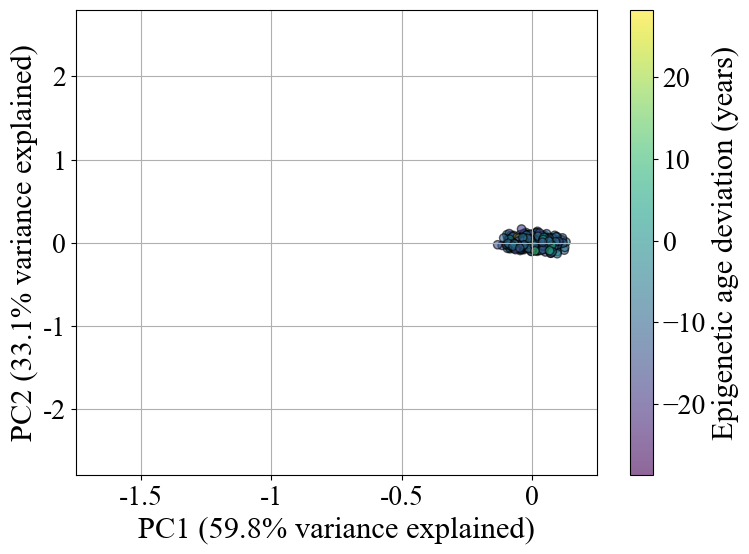

In [24]:
# Set the desired x and y axis limits based on other RPCA plot
x_limits = (-1.75, 0.25)  
y_limits = (-2.8, 2.8)  

# Define a formatter function
def flexible_format(x, pos):
    if x.is_integer():
        return f'{int(x)}'
    else:
        return f'{x:.1f}'

# Load data from ordination file
ordination_file = 'phylo_rpca_results/ordination.txt'

# Extract variance explained from the "Proportion explained" line
with open(ordination_file, 'r') as file:
    lines = file.readlines()
    explained_variance = [float(value) for value in lines[4].strip().split('\t')]

# Extract PCA scores from "Site" section (starting at line where it appears)
pca_scores_start = lines.index("Site\t311\t3\n") + 1
pca_scores = [line.strip().split('\t') for line in lines[pca_scores_start:pca_scores_start + 311]]
pca_scores_df = pd.DataFrame(pca_scores, columns=['Sample', 'PC1', 'PC2', 'PC3']).astype({'PC1': float, 'PC2': float, 'PC3': float})

# Plot PCA with Epigenetic Deviation (assuming it's loaded as epigenetic_deviation)
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

# Scatter plot with color gradient based on Epigenetic Deviation
scatter = ax.scatter(
    pca_scores_df['PC1'],  # PC1 scores
    pca_scores_df['PC2'],  # PC2 scores
    c=df["Epigenetic_deviation"],   # Color by Epigenetic Deviation
    cmap=COLOR_MAP,
    alpha=ALPHA_SCATTER,
    edgecolor=EDGE_COLOR
)

# Add color bar for continuous variable
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Epigenetic age deviation (years)', fontsize=LABEL_SIZE)

# Add axis labels and grid with explained variance
ax.set_xlabel(f'PC1 ({explained_variance[0] * 100:.1f}% variance explained)')
ax.set_ylabel(f'PC2 ({explained_variance[1] * 100:.1f}% variance explained)')
ax.grid(True)

# Apply consistent x and y axis limits
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

# Set flexible formatting for x-axis and y-axis
ax.xaxis.set_major_formatter(FuncFormatter(flexible_format))
ax.yaxis.set_major_formatter(FuncFormatter(flexible_format))

# Save and display the figure
plt.tight_layout()
plt.savefig("phylo_rpca_epigenetic_deviation.png", format="png", dpi=DPI, bbox_inches="tight")
plt.show()


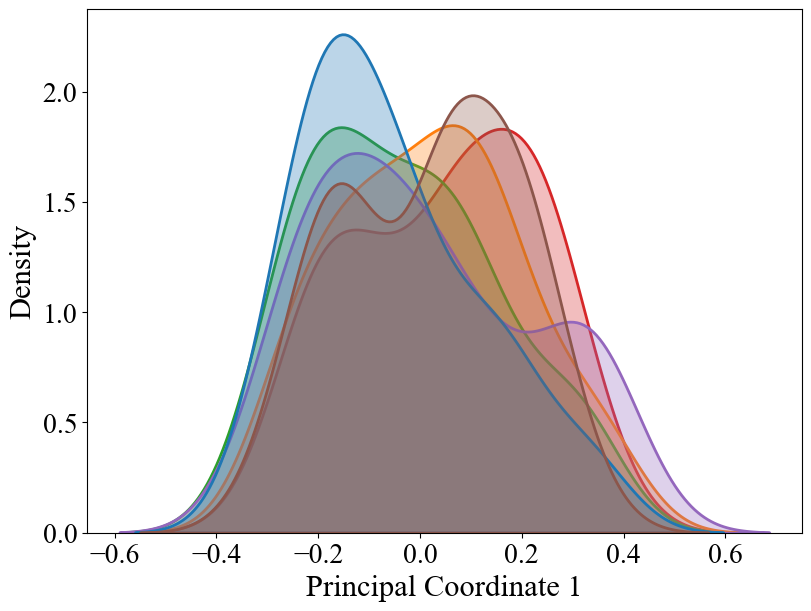

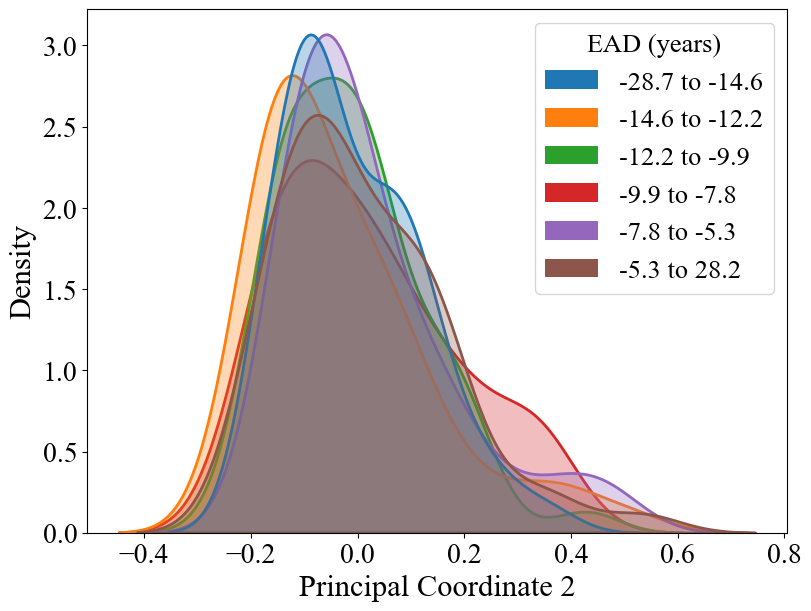

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define the number of bins for Epigenetic Deviation (quartiles)
NUM_BINS = 6
BANDWIDTH_ADJUST = 1  # Increase to smoothen the curve

pca = bc_scores

# Create quartile bins with labels for Epigenetic Deviation using pd.qcut
pca['Epigenetic_deviation_bin'] = pd.qcut(
    pca['Epigenetic_deviation'],
    q=NUM_BINS,
    duplicates='drop',  # Handle potential duplicate edges
    labels=False
)

# If duplicates='drop' causes fewer bins, adjust NUM_BINS accordingly
actual_bins = pca['Epigenetic_deviation_bin'].nunique()

# Retrieve the quartile edges
quartile_edges = pca['Epigenetic_deviation'].quantile([i/NUM_BINS for i in range(NUM_BINS+1)]).values

# Format the bin labels with 1 digit after the decimal
bin_labels = [f'{quartile_edges[i]:.1f} to {quartile_edges[i+1]:.1f}' for i in range(NUM_BINS)]

# Assign the labels to the bins
pca['Epigenetic_deviation_bin'] = pca['Epigenetic_deviation_bin'].apply(lambda x: bin_labels[x] if pd.notnull(x) else x)

# Ensure there are no NaN values in the 'Epigenetic_deviation_bin' column
pca = pca.dropna(subset=['Epigenetic_deviation_bin'])

# Function to plot density for a single principal component
def plot_density(df, pc, hue, xlabel, ylabel, filename, show_legend=True):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), constrained_layout=True)
    
    # Define the color palette
    hue_categories = sorted(df[hue].unique(), key=lambda x: float(x.split(' to ')[0]))
    palette = sns.color_palette('tab10', len(hue_categories))
    palette_dict = dict(zip(hue_categories, palette))
    
    # Density plot for the specified principal component
    sns.kdeplot(
        data=df,
        x=pc,
        hue=hue,
        common_norm=False,
        fill=True,
        alpha=ALPHA_DENSITY,
        ax=ax,
        legend=False,
        palette=palette_dict,
        bw_adjust=BANDWIDTH_ADJUST,
        linewidth=2  # Thicker density lines
    )
    ax.set_xlabel(xlabel, fontsize=LABEL_SIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    
    if show_legend:
        # Sort the hue categories based on the numerical start of each range
        hue_categories_sorted = sorted(hue_categories, key=lambda x: float(x.split(' to ')[0]))
        
        # Create custom legend handles
        legend_handles = [Patch(facecolor=palette_dict[label], label=label) for label in hue_categories_sorted]
        
        ax.legend(
            handles=legend_handles,
            title='EAD (years)',
            fontsize=LEGEND_SIZE,
            title_fontsize=LEGEND_SIZE
        )
    
    # Save and display the plot
    plt.savefig(filename, format="png", dpi=DPI)
    plt.show()

# Plot and save density plot for PC1 with legend
plot_density(
    df=pca,
    pc='PC1',
    hue='Epigenetic_deviation_bin',
    xlabel='Principal Coordinate 1',
    ylabel='Density',
    filename='density_bc_PC1.png',
    show_legend=False
)

# Plot and save density plot for PC2 without legend
plot_density(
    df=pca,
    pc='PC2',
    hue='Epigenetic_deviation_bin',
    xlabel='Principal Coordinate 2',
    ylabel='Density',
    filename='density_bc_PC2.png',
    show_legend=True
)


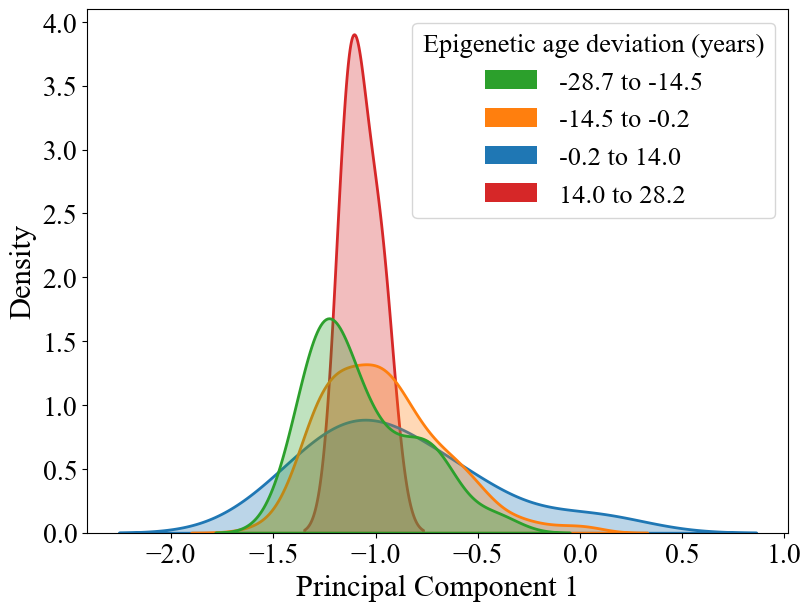

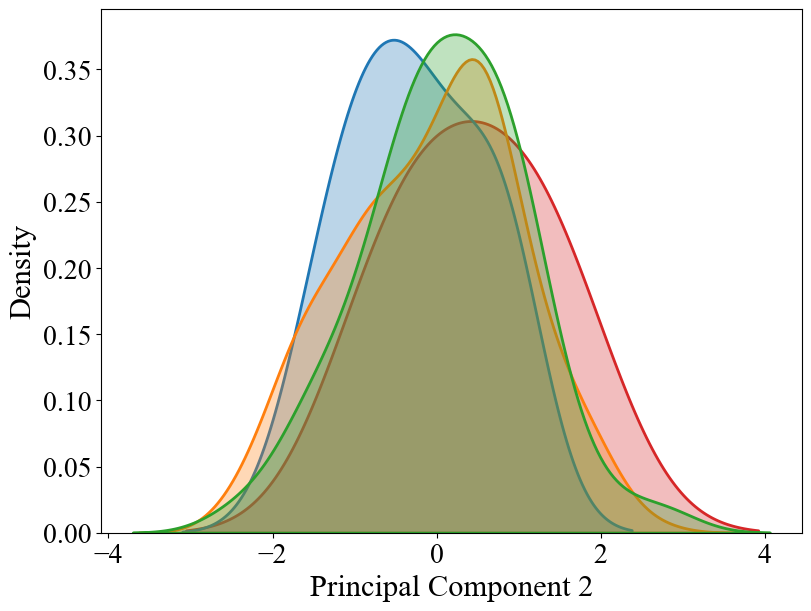

In [ ]:
# Define the number of bins for Epigenetic Deviation
NUM_BINS = 4
BANDWIDTH_ADJUST = 1  # Increase to smoothen the curve

# Prepare the DataFrame for plotting
pca = pd.DataFrame({
    'PC1': pca_sample_scores["0"],
    'PC2': pca_sample_scores["1"],
    'Epigenetic_deviation': filtered_df['Epigenetic_deviation']
})

# Create bins with labels for Epigenetic Deviation
# First, create the bins without labels
pca['Epigenetic_deviation_bin'] = pd.cut(
    pca['Epigenetic_deviation'],
    bins=NUM_BINS,
    include_lowest=True
)

# Retrieve the bin edges
bin_edges = pca['Epigenetic_deviation_bin'].cat.categories

# Format the bin labels with 1 digit after the comma
bin_labels = [f'{interval.left:.1f} to {interval.right:.1f}' for interval in bin_edges]

# Assign the labels to the bins using rename_categories
pca['Epigenetic_deviation_bin'] = pca['Epigenetic_deviation_bin'].cat.rename_categories(bin_labels)

# Ensure there are no NaN values in the 'Epigenetic_deviation_bin' column
pca = pca.dropna(subset=['Epigenetic_deviation_bin'])

# Function to plot density for a single principal component
def plot_density(df, pc, hue, xlabel, ylabel, filename, show_legend=True):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), constrained_layout=True)
    
    # Define the color palette
    hue_categories = sorted(df[hue].unique())
    palette = sns.color_palette('tab10', len(hue_categories))
    palette_dict = dict(zip(hue_categories, palette))
    
    # Density plot for the specified principal component
    sns.kdeplot(
        data=df,
        x=pc,
        hue=hue,
        common_norm=False,
        fill=True,
        alpha=ALPHA_DENSITY,
        ax=ax,
        legend=False,
        palette=palette_dict,
        bw_adjust=BANDWIDTH_ADJUST,
        linewidth=2  # Thicker density lines
    )
    ax.set_xlabel(xlabel, fontsize=LABEL_SIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    
    if show_legend:
        # Sort the hue categories based on the numerical start of each range
        hue_categories_sorted = sorted(hue_categories, key=lambda x: float(x.split(' to ')[0]))
        
        # Create custom legend handles
        legend_handles = [Patch(facecolor=palette_dict[label], label=label) for label in hue_categories_sorted]
        
        ax.legend(
            handles=legend_handles,
            title='Epigenetic age deviation (years)',
            fontsize=LEGEND_SIZE,
            title_fontsize=LEGEND_SIZE
        )
    
    # Save and display the plot
    plt.savefig(filename, format="png", dpi=DPI)
    plt.show()

# Plot and save density plot for PC1 with legend
plot_density(
    df=pca,
    pc='PC1',
    hue='Epigenetic_deviation_bin',
    xlabel='Principal Component 1',
    ylabel='Density',
    filename='density_PC1.png',
    show_legend=True
)

# Plot and save density plot for PC2 without legend
plot_density(
    df=pca,
    pc='PC2',
    hue='Epigenetic_deviation_bin',
    xlabel='Principal Component 2',
    ylabel='Density',
    filename='density_PC2.png',
    show_legend=False
)


C:\Users\MEDV3721\AppData\Local\Temp\ipykernel_8780\4204574875.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


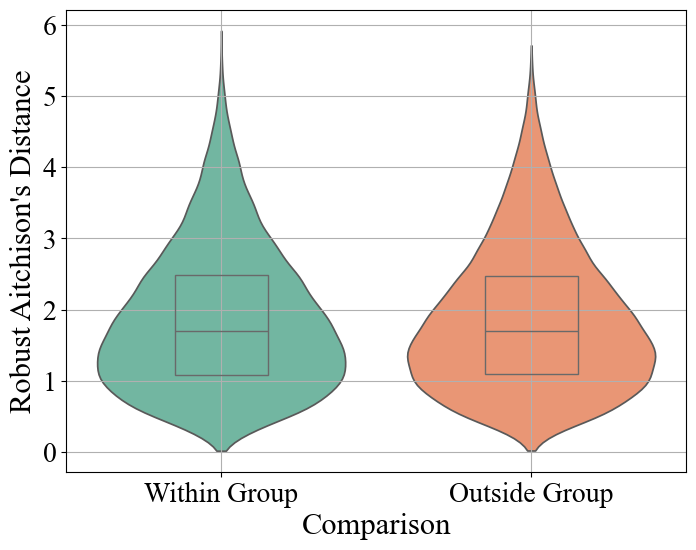

C:\Users\MEDV3721\AppData\Local\Temp\ipykernel_8780\4204574875.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


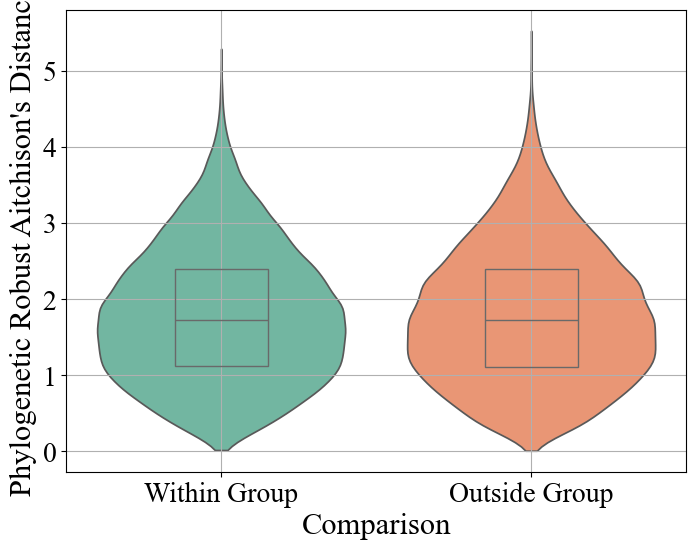

In [13]:

distance_matrix_rpca = distance_matrix
distance_matrix_phylo_rpca = pd.read_csv("phylo_rpca_results/distance-matrix.tsv", sep='\t', index_col=0)

# Function to plot within vs outside group distances without p-values and titles
def plot_group_distances(distance_matrix, group_labels, y_label, output_filename):
    # Initialize lists to store distances
    within_group_distances = []
    outside_group_distances = []

    # Calculate pairwise distances for within and outside groups
    n_samples = distance_matrix.shape[0]
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if group_labels[i] == group_labels[j]:  # Within group
                within_group_distances.append(distance_matrix.iloc[i, j])
            else:  # Outside group
                outside_group_distances.append(distance_matrix.iloc[i, j])

    # Create a DataFrame for plotting
    distance_data = pd.DataFrame({
        'Distance': within_group_distances + outside_group_distances,
        'Comparison': ['Within Group'] * len(within_group_distances) + ['Outside Group'] * len(outside_group_distances)
    })

    # Create violin plot without inner annotations
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
    sns.violinplot(
        x='Comparison',
        y='Distance',
        data=distance_data,
        palette="Set2",
        cut=0,
        ax=ax,
        inner=None  # Remove the default inner annotations
    )

    # Overlay a boxplot to display statistics as a box with three lines (quartiles)
    sns.boxplot(
        x='Comparison',
        y='Distance',
        data=distance_data,
        width=0.3,  # Increase width to make the box wider
        color='grey',  # Set the color of all elements to grey
        ax=ax,
        showcaps=False,  # Remove the caps on the whiskers
        boxprops={'facecolor': 'none', 'edgecolor': 'dimgrey'},  # Transparent box with grey edges
        medianprops={'color': 'dimgrey'},  # Set median line to grey
        whiskerprops={'linewidth': 0},  # Remove the whiskers
        showfliers=False,  # Do not show outliers
        zorder=2  # Draw boxplot on top of violin plot
    )

    # Customize plot with global settings
    ax.set_ylabel(y_label, fontsize=LABEL_SIZE)
    ax.set_xlabel('Comparison', fontsize=LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.grid(True)

    # Save and display plot
    plt.savefig(output_filename, format="png", dpi=DPI, bbox_inches="tight")
    plt.show()

# Plot for regular RPCA
plot_group_distances(
    distance_matrix_rpca,
    filtered_df['Group'].values,
    "Robust Aitchison's Distance",
    'R_Aitchisons_Distance_Regular_RPCA.png'
)

# Plot for phylogenetic RPCA
plot_group_distances(
    distance_matrix_phylo_rpca,
    filtered_df['Group'].values,
    "Phylogenetic Robust Aitchison's Distance",
    'R_Aitchisons_Distance_Phylo_RPCA.png'
)


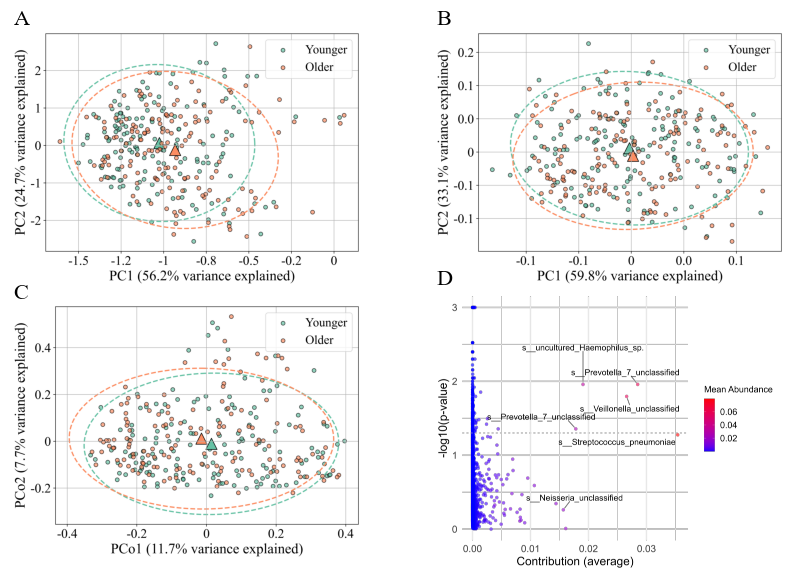

In [113]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from matplotlib.gridspec import GridSpec

# List of images and their labels
images = [
    ('pca_normal_final.png', 'A'),
    ('pca_phylo_final.png', 'B'),
    ('pcoa_bc_final.png', 'C'),
    ('../mean_abundance_plot.png', 'D')
    #('density_bc_PC1.png', 'D'),
    #('density_bc_PC2.png', 'E')
]

# Check if all files exist
for img_path, _ in images:
    if not os.path.isfile(img_path):
        raise FileNotFoundError(f"File not found: {img_path}")

# Create a figure
fig = plt.figure(figsize=(10, 8))

# Define GridSpec with no vertical spacing
gs = GridSpec(2, 2, figure=fig, hspace=-0.2)

# Adjust layout to decrease vertical space between rows
plt.subplots_adjust(hspace=-0.1)  # Use a negative hspace value


# Iterate over images and plot them
for idx, (img_path, label) in enumerate(images):
    row = idx // 2
    col = idx % 2
    ax = fig.add_subplot(gs[row, col])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    # Add subplot labels at the top-left corner without brackets
    ax.text(
        0.01, 1.075, label, transform=ax.transAxes,
        fontsize=16, va='top', ha='left'
    )

# Save the composite figure with high resolution
plt.savefig('composite_figure2.png', dpi=600, bbox_inches='tight')

# Show the plot (optional)
plt.show()


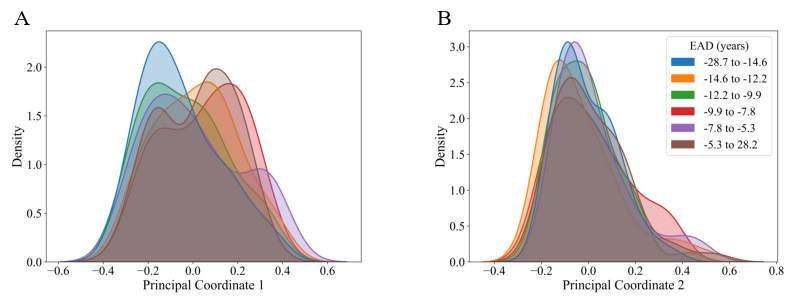

In [114]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from matplotlib.gridspec import GridSpec

# List of images and their labels
images = [
    ('density_bc_PC1.png', 'A'),
    ('density_bc_PC2.png', 'B'),
   
]

# Check if all files exist
for img_path, _ in images:
    if not os.path.isfile(img_path):
        raise FileNotFoundError(f"File not found: {img_path}")

# Create a figure
fig = plt.figure(figsize=(10, 8))

# Define GridSpec with no vertical spacing
gs = GridSpec(1, 2, figure=fig, hspace=-0.2)

# Adjust layout to decrease vertical space between rows
plt.subplots_adjust(hspace=-0.1)  # Use a negative hspace value


# Iterate over images and plot them
for idx, (img_path, label) in enumerate(images):
    row = idx // 2
    col = idx % 2
    ax = fig.add_subplot(gs[row, col])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    # Add subplot labels at the top-left corner without brackets
    ax.text(
        0.01, 1.075, label, transform=ax.transAxes,
        fontsize=16, va='top', ha='left'
    )

# Save the composite figure with high resolution
plt.savefig('Supp_2.png', dpi=600, bbox_inches='tight')

# Show the plot (optional)
plt.show()
